# Coursework

学生信息：


Importing all libraries

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties
# import seaborn as sns

## Data preparation

### Data import

In [5]:
data_file = 'pue.csv'
all_data = np.genfromtxt(data_file, 
                         delimiter=',', 
                         skip_header=1, 
                         skip_footer=5, 
                         dtype=np.float64, # check casting
                         encoding='gb2312')

### Picking features

In [6]:
from sklearn.decomposition import PCA

# x 输入数据
# reduction_components 降维到多少维（2或3）
def pca_reduction(x, reduction_components):
    pca = PCA(n_components = reduction_components) # 降维
    pca.fit(x) # 训练
    newX = pca.fit_transform(x) # 降维后的数据
    
    return newX

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


# normalize 是否进行归一化
# reduction 是否降维
# select_count 特征选择的个数
# reduction_components 降维到多少维（2或3）
def feature_selection(data, normalize=True, reduction=True, select_count=10, reduction_components=2):
    
    # TODO: change into one cycle
    # 数据
    x_64 = data[:, :64].copy()                    # 前64维
    x_other = data[:, 64:-2].copy()               # 非前64维
    y = data[:, -1].copy()                        # pue 
    time = data[:, -2].copy()                     # time
    
    # 归一化，所有特征都进行归一化
    if normalize == True:       
        scaler = MinMaxScaler()   
        x_64 = scaler.fit_transform(x_64)
        x_other = scaler.fit_transform(x_other)

    # 特征选择，只对【非前64维度的特征】进行特征选择
    fs = SelectKBest(score_func=f_regression, k=select_count)
    X_selected = fs.fit_transform(x_other, y)

    
    # PCA降维
    if reduction == True:
        X_selected = pca_reduction(X_selected, reduction_components)

        
    # 将前64维和处理后的特征拼接在一起
    return np.append(x_64,X_selected,axis=1), y, time

In [9]:
# 结果 = 前64维 + 【非前64维特征】特征选择后的特征

X, Y, time = feature_selection(all_data, reduction=False, select_count=20) 


print(X.shape)
print(Y.shape)
print(time.shape)

(2272, 84)
(2272,)
(2272,)


/Users/Alexey/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


#### window + data split
> 目前比使用

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#     series = tf.expand_dims(series, axis=-1)

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    
    return ds.batch(batch_size).prefetch(1)

In [11]:
split_time = 2048
window_size = 32
batch_size = 64
shuffle_buffer_size = 512

time_train = time[:split_time]
x_train = X[:split_time]
y_train = Y[:split_time]

time_valid = time[split_time:]
x_valid = X[split_time:]
y_valid = Y[split_time:]
# t_set = np.column_stack((x_train, y_train))

x_train = np.expand_dims(x_train, axis=1)
x_valid = np.expand_dims(x_valid, axis=1)
y_train = np.expand_dims(y_train, axis=1)
y_valid = np.expand_dims(y_valid, axis=1)

In [12]:
# train_set = windowed_dataset(t_set, window_size, batch_size, shuffle_buffer_size)

# print(x_train.shape)
# print(train_set)

(2048, 1, 84)
<PrefetchDataset shapes: ((None, None, 85), (None, None, 85)), types: (tf.float64, tf.float64)>


## Define model

First run is for checking which learning rate produces lowest loss

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

1. 在这里先指定想训练的模型机构：层数，神经数，optimizer，loss，等等。也试一下多种数据状态
2. 然后看一下图，可以选learning_rate，对adam、nadam、等等optimizer，可以跳过去这一步
3. 每次调参数后使用`plot_learning_curves`来判断有没有overfitting什么的。
4. 我还推荐使用 `keras.callbacks.EarlyStopping` 和 `keras.callbacks.ModelCheckpoint`
5. 如果觉得训练了比较好的模型，自己保存到文档

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[None, x_train.shape[-1]]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
    ),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# model.summary()

In [14]:
history = model.fit(x_train,y_train, 
                    epochs=100, 
                    callbacks=[lr_schedule]
                   )

Epoch 1/100
64/64 [==============================] - 0s 2ms/step - loss: 1.0056 - mae: 1.5056 - lr: 1.0000e-08
Epoch 2/100
64/64 [==============================] - 0s 2ms/step - loss: 1.0056 - mae: 1.5056 - lr: 1.1220e-08
Epoch 3/100
64/64 [==============================] - 0s 2ms/step - loss: 1.0056 - mae: 1.5056 - lr: 1.2589e-08
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 1.0055 - mae: 1.5055 - lr: 1.4125e-08
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 1.0055 - mae: 1.5055 - lr: 1.5849e-08
Epoch 6/100
64/64 [==============================] - 0s 2ms/step - loss: 1.0055 - mae: 1.5055 - lr: 1.7783e-08
Epoch 7/100
64/64 [==============================] - 0s 2ms/step - loss: 1.0054 - mae: 1.5054 - lr: 1.9953e-08
Epoch 8/100
64/64 [==============================] - 0s 2ms/step - loss: 1.0054 - mae: 1.5054 - lr: 2.2387e-08
Epoch 9/100
64/64 [==============================] - 0s 2ms/step - loss: 1.0054 - mae: 1.5054 - lr: 2.5119e-08
E

Plot first run results, and the lowest loss is around `lr = 1e-4`

(1e-08, 0.0009, 0.0, 1.0)

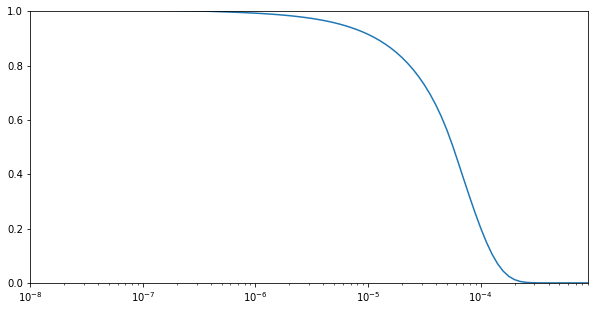

In [15]:
plt.figure(figsize=(10, 5))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 9e-4, 0, 1])

### Improving model architecture + Finetuning
> TODO：调模型参数

### Actual training

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[None, x_train.shape[-1]]),
  tf.keras.layers.Conv1D(filters=64, 
                         kernel_size=5,
                         strides=1, 
                         padding="causal",
                         activation="relu",
                        ),
    
  tf.keras.layers.LSTM(512, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(128, activation="elu"),
  tf.keras.layers.Dense(64, activation="elu"),
  tf.keras.layers.Dense(1),

])

optimizer = tf.keras.optimizers.Nadam()
# optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9) # change

model.compile(
    loss="mse",
    optimizer=optimizer,
    metrics=["mae"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          26944     
_________________________________________________________________
lstm (LSTM)                  (None, None, 512)         1181696   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         328192    
_________________________________________________________________
dense (Dense)                (None, None, 128)         16512     
_________________________________________________________________
dense_1 (Dense)              (None, None, 64)          8256      
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           65        
Total params: 1,561,665
Trainable params: 1,561,665
Non-trainable params: 0
______________________________________________

In [39]:
history = model.fit(x_train, y_train, epochs=20,
                   validation_data=(x_valid,y_valid))

Epoch 1/20
64/64 [==============================] - 2s 32ms/step - loss: 0.1558 - mae: 0.2106 - val_loss: 0.0129 - val_mae: 0.0857
Epoch 2/20
64/64 [==============================] - 2s 24ms/step - loss: 0.0093 - mae: 0.0844 - val_loss: 0.0150 - val_mae: 0.0822
Epoch 3/20
64/64 [==============================] - 1s 23ms/step - loss: 0.0081 - mae: 0.0684 - val_loss: 0.0082 - val_mae: 0.0631
Epoch 4/20
64/64 [==============================] - 2s 24ms/step - loss: 0.0052 - mae: 0.0560 - val_loss: 0.0251 - val_mae: 0.1398
Epoch 5/20
64/64 [==============================] - 2s 24ms/step - loss: 0.0022 - mae: 0.0361 - val_loss: 0.0155 - val_mae: 0.1008
Epoch 6/20
64/64 [==============================] - 2s 24ms/step - loss: 0.0034 - mae: 0.0443 - val_loss: 0.0141 - val_mae: 0.0966
Epoch 7/20
64/64 [==============================] - 1s 23ms/step - loss: 0.0039 - mae: 0.0470 - val_loss: 0.0062 - val_mae: 0.0494
Epoch 8/20
64/64 [==============================] - 2s 24ms/step - loss: 0.0038 - m

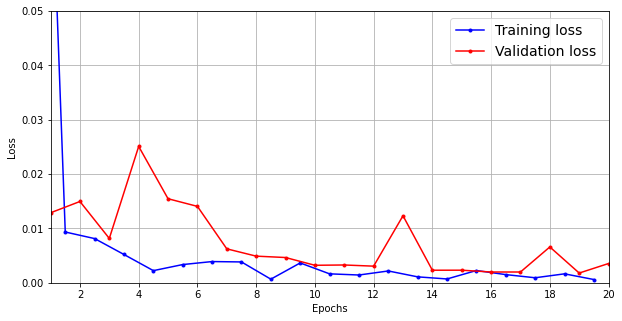

In [40]:
plt.figure(figsize=(10,5))
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Plotting forecast of a trained model

In [19]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [24]:
def model_forecast(model, series, window_size):
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(window_size, shift=1, drop_remainder=True)
#     ds = ds.flat_map(lambda w: w.batch(window_size))
#     ds = ds.batch(32).prefetch(1)
    forecast = model.predict(series)
    return forecast

In [42]:
rnn_forecast = model_forecast(model, x_valid, window_size)
rnn_forecast = rnn_forecast[:, 0, 0]

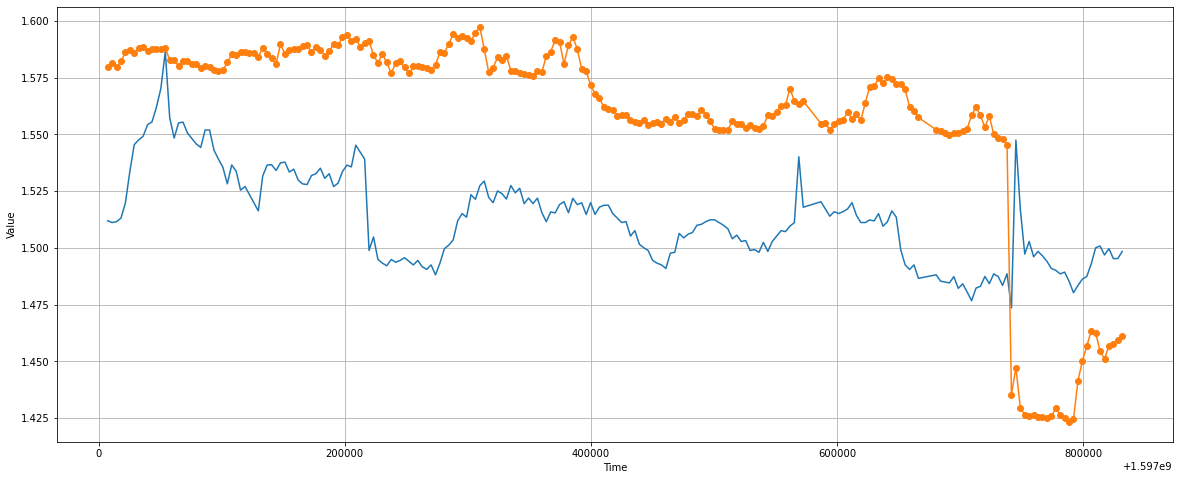

In [46]:
plt.figure(figsize=(20, 8))

# unseen vs 
plot_series(time_valid, y_valid)
plot_series(time_valid, rnn_forecast, format='-o')

actual mae

In [33]:
# tf.keras.metrics.mean_absolute_error(y_valid, rnn_forecast)

<tf.Tensor: shape=(224,), dtype=float32, numpy=
array([0.06221267, 0.06280155, 0.06250688, 0.061317  , 0.05631988,
       0.04856522, 0.04629008, 0.04609579, 0.04596727, 0.04558561,
       0.04550238, 0.0453688 , 0.04562552, 0.0518559 , 0.04540374,
       0.04603094, 0.0455301 , 0.04550794, 0.0458492 , 0.0460413 ,
       0.04626097, 0.04642896, 0.04575125, 0.04575125, 0.04658827,
       0.04719857, 0.04799294, 0.05082388, 0.04775279, 0.04851233,
       0.05246945, 0.05149162, 0.05373175, 0.05625084, 0.05891771,
       0.04923957, 0.04776623, 0.04772584, 0.04841016, 0.04754812,
       0.04746712, 0.04863477, 0.04823511, 0.05002069, 0.05084863,
       0.05100748, 0.04918279, 0.04888959, 0.04811167, 0.04966596,
       0.04888959, 0.05151653, 0.0506704 , 0.04856522, 0.04776623,
       0.04795688, 0.04631327, 0.04670389, 0.04718867, 0.07225789,
       0.06768221, 0.07529624, 0.07652034, 0.07743854, 0.07530878,
       0.07622753, 0.07561707, 0.07469888, 0.07591145, 0.07714764,
       0.07562